# Predicting a Patient's Heart Condition

## Introduction

* Introduce the topic
    * What heart disease is, the different variations of it, why it's dangerous, why it's important to be able to predict if a patient has it, etc.
* Introduce our dataset
    * Where we got it from (link), what the variables are, what our class variable is
* Add some pictures!

## Methods

* We will be predicting the ___ class, so we must choose the most optimal predictor variables that are to be implimented into our model.
* Our steps: Read and Tidy the data, then split the data, create multiple recipes for different predictor variables, test them and evaluate which ones are the most accurate, find the best k value to make the best model, analyze our results.


## Reading and Wrangling the Dataset

#### Loading libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 7) #limits output of dataframes to 7 instances

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Reading in and tidying the dataset
* Since the dataset can be read from the internet, it is best to use a URL to read in the dataset, as that would allow for reading of the data without the need for a local file.
* The dataset does not have any column headers, so we can store the names of each variable within a vector according to their reffered labels on the description from the source.
* Many of the variables were of a categoric type, so `as_factor()` was used to convert them to their appropriate data type.
* The Fasting Blood Sugar levels were converted to a logical type, as the dataset represents them with either `true`, for an FBS level greater than 120 mg/dl, and `false` for anything less than or equal to that.
* Since many of the possible predictor variables are not continuous (are categoric), we will have to omit these variables as possible predictors, as using categoric variables as predictor variables is something outside of the scope of DSCI 100.
    * However, we will keep them in the dataset so that we do not lose possibly valuable information.
    * This now leaves us with 6 possible predictor variables that we can use to build our K-NN classification model.

In [2]:
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
patient_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = names) |>
    mutate(num = as_factor(num)) |>
    mutate(cp = as_factor(cp)) |>
    mutate(sex = as_factor(sex)) |>
    mutate(exang = as_factor(exang)) |>
    mutate(slope = as_factor(slope)) |>
    mutate(restecg = as_factor(restecg)) |>
    mutate(ca = as_factor(ca)) |>
    mutate(thal = as_factor(thal)) |>
    mutate(fbs = as.logical(fbs))
patient_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<lgl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,TRUE,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,FALSE,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,FALSE,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,FALSE,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,FALSE,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,FALSE,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,FALSE,0,173,0,0.0,1,?,3.0,0


#### Splitting the data
* We have decided to split our dataset of 303 instances into a 75% training-testing split, where 75% of our total data will be alloted to our training set to be used in our analyis, cross-validation, and model training, while the other 25% will be used to evaluate our completed model.
* A seed of 59 is also set with `set.seed()` so that our results can be reproduced consistently through the randomness of `initial_split()`.

In [3]:
set.seed(59)
patient_split <- initial_split(patient_data, prop = 0.75, strata = num)
patient_training <- training(patient_split)
patient_testing <- testing(patient_split)

patient_training

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<lgl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
37,1,3,130,250,FALSE,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,FALSE,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,FALSE,0,178,0,0.8,1,0.0,3.0,0
57,1,4,140,192,FALSE,0,148,0,0.4,2,0.0,6.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,0,4,128,205,FALSE,1,130,1,2.0,2,1.0,7.0,3
59,1,4,164,176,TRUE,2,90,0,1.0,2,2.0,6.0,3
57,1,4,130,131,FALSE,0,115,1,1.2,2,1.0,7.0,3


## Summarizing the Training Data
* As stated above, our total dataset contains 303 instances, and since our training set is 75% of that, we would have 225 instances in our training set.

In [4]:
n_for_nums <- patient_training |>
    group_by(num) |>
    summarize(n = n())
n_for_nums

num,n
<fct>,<int>
0,123
1,40
2,26
3,26
4,10


* By using `group_by()` with `num` as its parameter, and `summarize()` with `n = n()` as its parameter, a tibble the contains the number of instances for each `num` type is created.
    * It is important to remember that we are only summarizing variables that are possible predictors.
* We can see here that most of our training data (around 55%) is composed of patients that do not have heart disease, which is a good reflection of real-world situations where heart disease is not a frequent diagnosis.
* The number of instances also appears to decrease as the severity of the diagnosis increases, which entails that severe heart diseases occur less in patients.

In [5]:
mean_per_diagonsis <- patient_training |>
    group_by(num) |>
    summarize(mean_age = mean(age), mean_trestbps = mean(trestbps), mean_chol = mean(chol), mean_thalach = mean(thalach), mean_oldpeak = mean(oldpeak))
mean_per_diagonsis

num,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,52.15447,129.2358,243.0163,158.5854,0.5731707
1,57.00000,135.5750,253.0750,148.7500,0.8975000
2,57.61538,129.6538,257.2308,136.9615,1.6615385
3,56.61538,131.9615,239.6538,130.7692,2.0961538
4,57.00000,138.4000,255.3000,142.0000,2.7700000


* Again, `group_by()` and `summarize()` were used to group the data by their `num` diagnoses, and then to find the means of all the data within those subgroups.
* We can see that patients with a `num` diagnosis of 0 are on average, around 5 years younger than patients who have heart disease. This could mean that age can be a factor on whether a patient has heart disease.
    * However, there seems to be no major trend in age when comparing between diagnoses of 1-4.
* Depression induced by exercize (`oldpeak`), seems to also have a correlation with the diagnosis of a patient, as there seems to be a positive relationship between the two.
    * `oldpeak` average increases as the diagnosis becomes more severe.

#### Visualizing the predictor variables

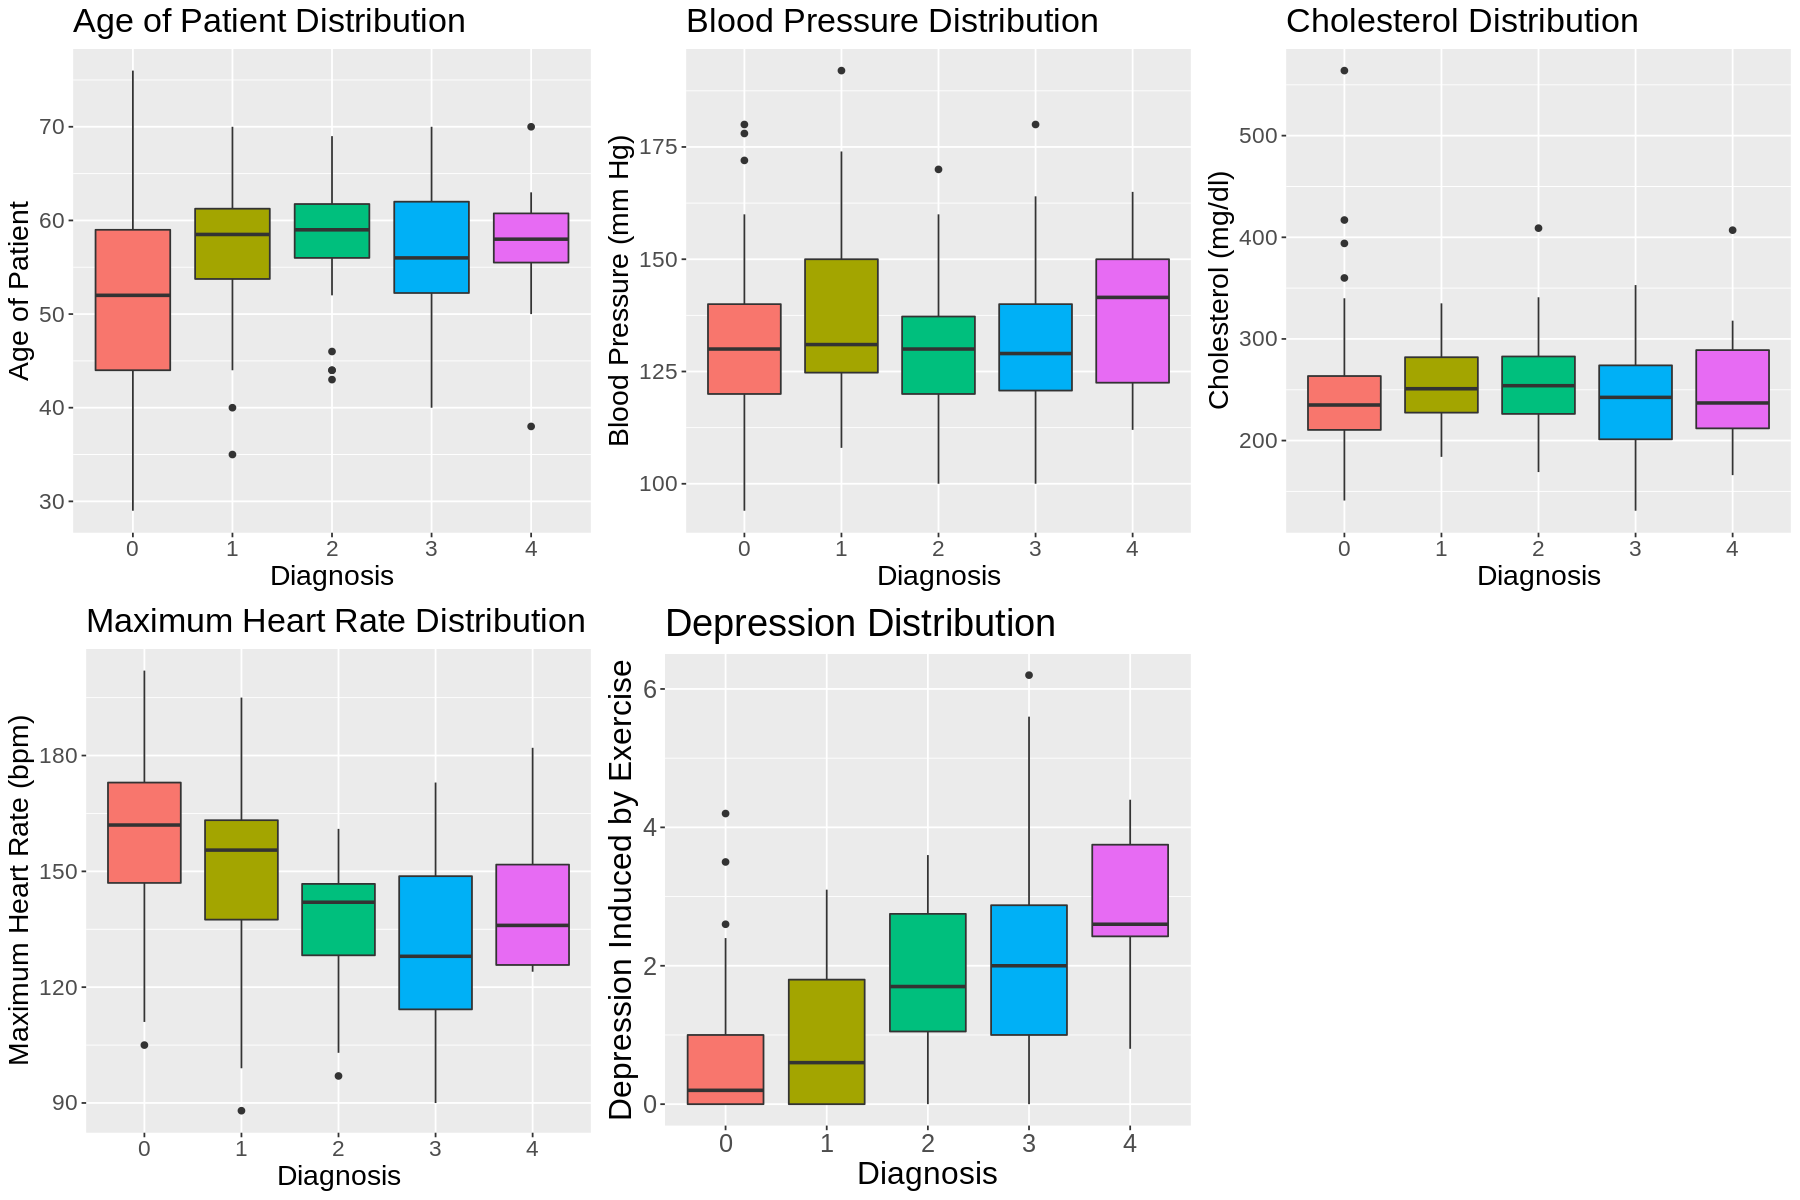

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)
age_boxplot <- patient_training |>
    ggplot(aes(x = num, y = age, fill = num)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Age of Patient") +
    ggtitle("Age of Patient Distribution") +
    theme(text = element_text(size = 17))
testbps_boxplot <- patient_training |>
    ggplot(aes(x = num, y = trestbps, fill = num)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Blood Pressure (mm Hg)") +
    ggtitle("Blood Pressure Distribution") +
    theme(text = element_text(size = 17))
chol_boxplot <- patient_training |>
    ggplot(aes(x = num, y = chol, fill = num)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Cholesterol (mg/dl)") +
    ggtitle("Cholesterol Distribution") +
    theme(text = element_text(size = 17))
thalach_boxplot <- patient_training |>
    ggplot(aes(x = num, y = thalach, fill = num)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Maximum Heart Rate (bpm)") +
    ggtitle("Maximum Heart Rate Distribution") +
    theme(text = element_text(size = 17))
oldpeak_boxplot <- patient_training |>
    ggplot(aes(x = num, y = oldpeak, fill = num)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Depression Induced by Exercise") +
    ggtitle("Depression Distribution") +
    theme(text = element_text(size = 19))
predictor_visualization <- plot_grid(age_boxplot, testbps_boxplot, chol_boxplot, thalach_boxplot, oldpeak_boxplot, ncol = 3)
predictor_visualization

* By utilizing `ggplot()` and `geom_boxplot()`, we can visualize the range of values between each predictor variable.
* We can see that for this specific train/testing split, our training data resulted in the variables `age`, `thalach`, `trestbps` and `oldpeak` varying the most across different diagnoses.
    * This means that they may have a significant impact on the diagnosis of a patient.
* However, this may be a seed-dependant result, as the randomness may have made the variable `chol` seem constant in mean across different diagnoses.
    * We must conduct further investigation on their impacts on the diagnosis of a patient.

## Analyzing and Selecting Predictor Variables

* To select our predictor variables, we will tune distinct models and create distinct recipes for each set of predictor variables, and then compare the accuracy of the models.
* We will set `neighbors` to `tune()` in our K-NN recipe in combination with 5-fold cross-validation so that each model that we compare will be at its best accuracy.
* The fitted dataset used to train the model will be the `patient_training` dataset, while the `patient_testing` dataset will be set aside for evaluating our model.
* Our overall analysis will be composed of 5 recipes, one K-NN specification, one 5-fold cross validaiton variable, and one final model with the optimal predictors and the optimal `k` value.